<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br>Assignment 2, Group 5 Project</h1>

---
<br>


#### **Your UNI** : jc5635
#### **Your Full names** : John Cheng
#### **Your AI Model Share Usernames**: jc5635
#### **Link to your Public Github repository** : https://github.com/johnc2024/HW_2
#### **Team member Contribution Percentages** : 100%



# **STEP 1: Import packages and extract the dataset**

In [3]:
# connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

In [5]:
# load libraries and download data
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

# **STEP 2: Preparing Data**

We first process the raw X-ray image data by extracting files, standardizing image counts across response categories (i.e. COVID, pneumonia, and normal X-rays), resizing images to 192 x 192 pixels and setting to RGB format, and defining response labels.

In [6]:
# extract all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'

categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2])

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1285.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-262.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-140.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3418.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3074.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2811.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3484.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2481.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-656.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1114.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3244.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-104.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-580.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1259.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-128.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID

In [7]:
print(fnames[0][0:10])

['COVID-19_Radiography_Dataset/COVID/images/COVID-1285.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-262.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-140.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3418.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3074.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2811.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3484.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2481.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-656.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1114.png']


In [8]:
# reduce image count to first 1345 per category
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]

In [9]:
# define preprocessor
from keras.preprocessing import image
import numpy as np
from PIL import Image, ImageDraw

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import, convert to RGB, and resize height and width
        img = (np.float32(img) - 1.)/(255 - 1.) # min max transformation
        img = img.reshape((192, 192 ,3)) # set new dimensions for Keras
        return img

# test preprocessor on an image file
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

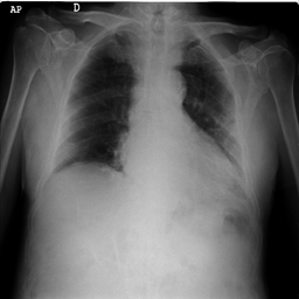

In [ ]:
Image.open(str(fnames[0][0]))

In [ ]:
# import image files iteratively and preprocess into array

# create list of file paths
image_filepaths = fnames[0] + fnames[1] + fnames[2]

# map preprocessor function to each filepath
preprocessed_image_data = list(map(preprocessor, image_filepaths))

# set feature input as array for Keras
X = np.array(preprocessed_image_data)

In [ ]:
print(len(X))           # same number of elements as filenames
print(X.shape)          # dimensions are now 192, 192, 3 for all images
print(X.min().round()) # min value of every image is zero
print(X.max() )         # max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
# create y data from correctly ordered labels
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid = list(repeat("COVID", 1344))
normal = list(repeat("NORMAL", 1344))
pneumonia = list(repeat("PNEUMONIA", 1344))

# combine into single list of y labels
y_labels = covid + normal + pneumonia

# check length
print(len(y_labels))

# one-hot encoding for Keras
import pandas as pd
y = pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


# **STEP 3: Visualizations <span style="color:yellow;">(5pts)</span>**

We display subsamples of raw X-ray images by response category as an initial step in our exploratory analysis.

In [ ]:
print(fnames[0][0], "\n", fnames[1][0], "\n", fnames[2][0])

# index for health conditions: 0 for COVID,
#                             1 for Normal,
#                             2 for Pneumonia

COVID-19_Radiography_Dataset/COVID/images/COVID-2854.png 
 COVID-19_Radiography_Dataset/Normal/images/Normal-6070.png 
 COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-653.png



 Sample of COVID X-Rays: 



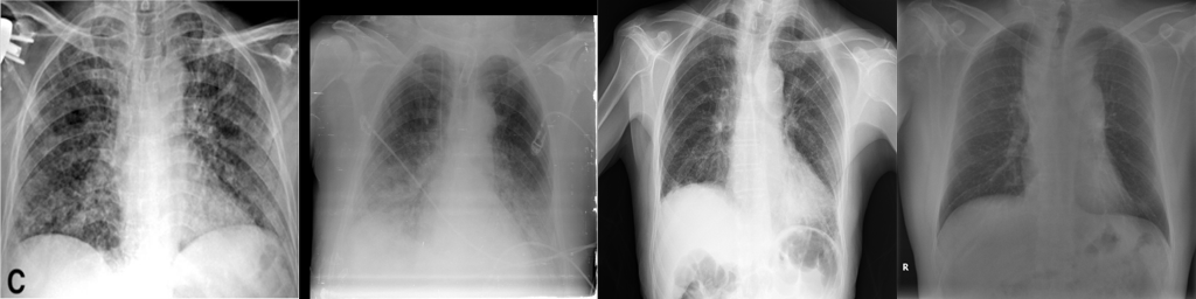


 Sample of Normal X-Rays: 



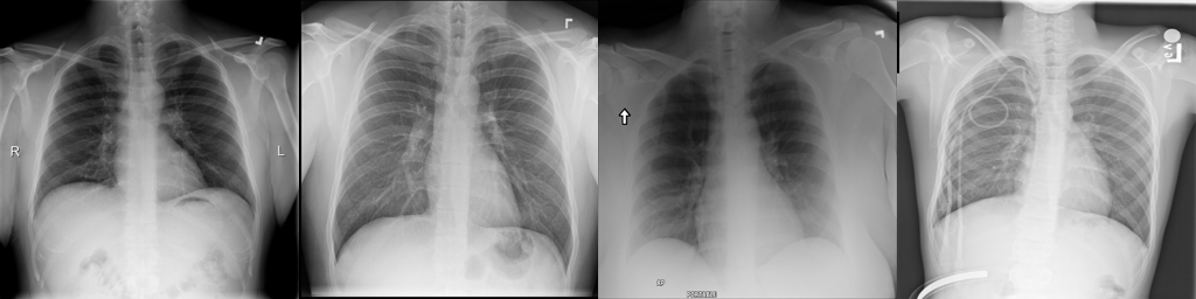


 Sample of Pneumonia X-Rays: 



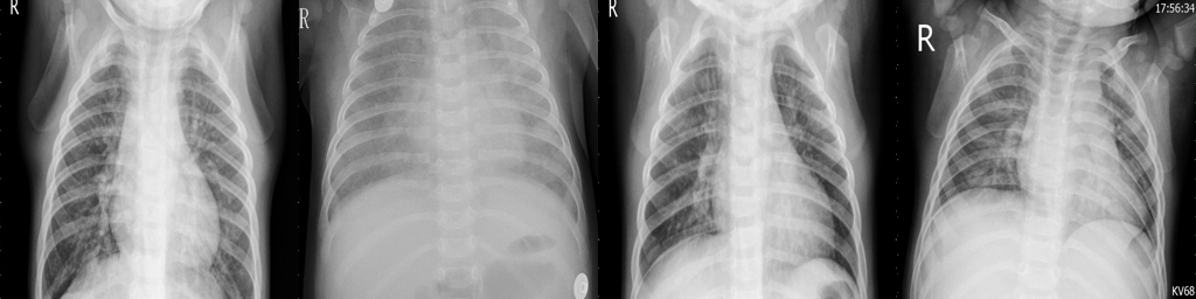

In [ ]:
# display image samples by condition
images = []
labels = ['COVID', 'Normal', 'Pneumonia']

for i in range(0, 3): # iterate through condition categories
  print("\n Sample of " + labels[i] + " X-Rays: \n")
  img_row = Image.new('RGB', (1196, 299))
  for j in range(0, 4): # iterate through images within category
    img_row.paste(Image.open(fnames[i][j]), (299 * j, 0))
  display(img_row)

# **STEP 4: Analyzing and Augmenting Dataset <span style="color:yellow;">(10pts)</span>**


As the next step in our exploratory analysis, we compare randomly selected pairs of COVID and pneumonia X-rays, COVID and normal X-rays, and pneumonia and normal X-rays using structural similarly index measures (SSIM), which may provide preliminary insight into how distinctive images are by response category. We find that the randomly selected COVID-pneumonia image pairing has an SSIM score of 0.492, higher than that of the randomly selected COVID-normal (0.326) and pneumonia-normal (0.359) image pairs.

NOTE: We will implement data augmentation concurrently with model training ( see Step 6). Random image flips and random image rotations will be applied to augment the dataset. Before doing so, we will first need to split the data into training and test sets (see Step 5). Data augmentation helps to minimize overfitting, as it can increase the extent to which the model is generalizable beyond the training data set.

In [ ]:
import cv2
import random
from skimage.metrics import structural_similarity as ssim

In [ ]:
# select process random images for SSIM scores
np.random.seed(1987)

rand_cov = random.choice(fnames[0])
rand_norm = random.choice(fnames[1])
rand_pneu = random.choice(fnames[2])

img_cov = cv2.imread(rand_cov, cv2.IMREAD_GRAYSCALE)
img_norm = cv2.imread(rand_norm, cv2.IMREAD_GRAYSCALE)
img_pneu = cv2.imread(rand_pneu, cv2.IMREAD_GRAYSCALE)

img_init = Image.new('RGB', (598, 299))

Structural similarity index measure (SSIM) for a randomly 
 selected pair of COVID and pneumonia X-rays: 0.49234



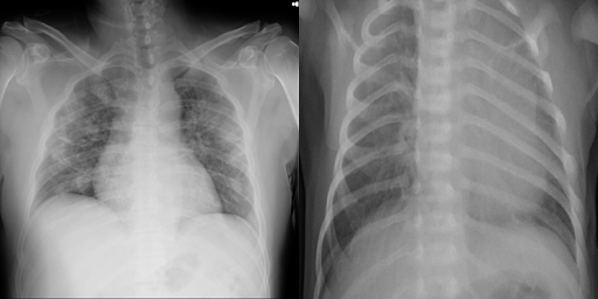

In [ ]:
# SSIM - COVID and pneumonia
np.random.seed(1987)

ssim_cov_pneu = round(ssim(img_cov, img_pneu), 5)
print("Structural similarity index measure (SSIM) for a randomly \n selected pair of COVID and pneumonia X-rays: " + str(ssim_cov_pneu) + "\n")

img_cov_pneu = img_init
img_cov_pneu.paste(Image.open(rand_cov), (0, 0))
img_cov_pneu.paste(Image.open(rand_pneu), (299, 0))
display(img_cov_pneu)


 Structural similarity index measure (SSIM) for a randomly 
 selected pair of COVID and normal X-rays: 0.32623



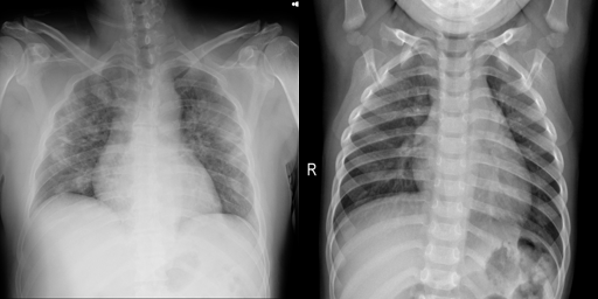

In [ ]:
# SSIM - COVID and normal
np.random.seed(1987)

ssim_cov_norm = round(ssim(img_cov, img_norm), 5)
print("\n Structural similarity index measure (SSIM) for a randomly \n selected pair of COVID and normal X-rays: " + str(ssim_cov_norm) + "\n")

img_cov_norm = img_init
img_cov_norm.paste(Image.open(rand_cov), (0, 0))
img_cov_norm.paste(Image.open(rand_norm), (299, 0))
display(img_cov_norm)


 Structural similarity index measure (SSIM) for a randomly 
 selected pair of pneumonia and normal X-rays: 0.35925



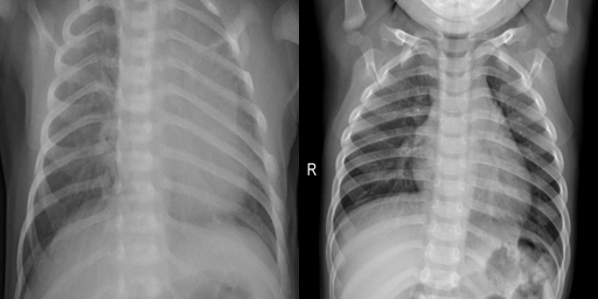

In [ ]:
# SSIM - pneumonia and normal
np.random.seed(1987)

ssim_pneu_norm = round(ssim(img_pneu, img_norm), 5)
print("\n Structural similarity index measure (SSIM) for a randomly \n selected pair of pneumonia and normal X-rays: " + str(ssim_pneu_norm) + "\n")

img_pneu_norm = img_init
img_pneu_norm.paste(Image.open(rand_pneu), (0, 0))
img_pneu_norm.paste(Image.open(rand_norm), (299, 0))
display(img_pneu_norm)

# **STEP 5: Splitting Dataset**

We prepare for model training by randomly splitting the X-ray image data into training and test sets according to a 2:1 ratio, as this helps to ensure that the test set is sufficiently large -- a relevant consideration for model generalizability. Data augmentation techniques, as implemented below, will help to address any overfitting that emerges in fitting candidate models to the training set.

In [ ]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

np.random.seed(1987)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

In [ ]:
# clear memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
# save data for reloading if runtime issues encountered
import pickle

with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [ ]:
# reload data
import pickle

with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

# **STEP 6: Model Training and Parameter Tuning <span style="color:yellow;"> (45pts)</span>**

We start by training two convolutional neural network (CNN) models and two transfer learning models (one VGG19, one ResNet50), and subsequently assess the training and validation accuracy, training and validation loss, and test performance of each of the models.

We set the same random seed throughout the training of each of the classification models to ensure reproducibility of results.

# **STEP 6(a): Custom CNN Models**

We train two custom CNN models, each consisting of 12 2d-convolution layers, five max-pooling layers, and a softmax activation layer. The choice of layer count is motivated by an interest in ensuring sufficient complexity in the trained models. We select categorical cross-entropy as the loss function for the models -- appropriate given the multi-class nature of our response data. Random horizontal image flips and 45-degree image rotations are applied in the models to address overfitting, a pertinent consideration in light of the modest size of the training dataset.

For the first CNN model, the training and validation accuracies peak at 0.335 and 0.341, respectively, and hover at approximately the same level across epochs. For the second CNN model, the training and validation accuracies manage to improve slightly to 0.333 and 0.413, respectively. The second CNN model is distinguished from the first by a switch from Adam to stochastic gradient descent (SGD) optimization and a doubling of the batch size from 64 to 128. It should be also noted that three dropout layers (rate = 0.1) are additionally introduced in the second CNN model to further address overfitting, which may have the effect of suppressing improvement in model performance.

A challenge encountered in the implementation of our CNN models is the substantial processing time required, likely related to the layer counts.


In [ ]:
# cnn_a

import tensorflow as tf
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

np.random.seed(1987)

with tf.device('/device:GPU:0'):

  cnn_a = tf.keras.Sequential([

    # data augmentation steps to reduce overfitting
    tf.keras.layers.RandomFlip("horizontal"), # random horizontal flips
    tf.keras.layers.RandomRotation(45), # random rotations

    # specify convolution, activation, max pooling layers
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 32, padding = 'same', activation = 'relu', input_shape = (192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 32, padding ='same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 64, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 64, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 128, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 128, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 1028, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 1028, padding = 'same', activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation = 'softmax')
  ])

  cnn_a.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

  # fit to training data
  hist_cnn_a = cnn_a.fit(X_train, y_train,
                   epochs = 5,
                   verbose = 1,
                   batch_size = 64,
                   validation_split = .2)
  hist_cnn_a # add model history

Epoch 1/5
35/35 [==============================] - 906s 26s/step - loss: 1.0995 - accuracy: 0.3353 - val_loss: 1.0986 - val_accuracy: 0.3406
Epoch 2/5
35/35 [==============================] - 869s 25s/step - loss: 1.0986 - accuracy: 0.3312 - val_loss: 1.0986 - val_accuracy: 0.3388
Epoch 3/5
35/35 [==============================] - 901s 26s/step - loss: 1.0995 - accuracy: 0.3139 - val_loss: 1.0986 - val_accuracy: 0.3388
Epoch 4/5
35/35 [==============================] - 894s 26s/step - loss: 1.0990 - accuracy: 0.3285 - val_loss: 1.0987 - val_accuracy: 0.3206
Epoch 5/5
35/35 [==============================] - 895s 26s/step - loss: 1.0987 - accuracy: 0.3257 - val_loss: 1.0987 - val_accuracy: 0.3206


In [ ]:
# save model
cnn_a.save('cnn_a.keras')
# tf.keras.models.load_model('cnn_a.keras')

In [ ]:
# save model history
np.save('cnn_a_history.npy',
        cnn_a.history)

# np.load('cnn_a_model_history.npy', allow_pickle = 'TRUE')

In [ ]:
cnn_a.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 192, 192, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 192, 192, 3)       0         
 otation)                                                        
                                                                 
 conv2d_24 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 192, 192, 32)      4128      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 96, 96, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 96, 96, 64)       

In [ ]:
# evaluate cnn_a model on test data
cnn_a_score, cnn_a_accuracy = cnn_a.evaluate(X_test, y_test)
print('Test score: ', cnn_a_score)
print('Test accuracy: ', cnn_a_accuracy)

41/41 [==============================] - 145s 3s/step - loss: 1.0986 - accuracy: 0.3331
Test score:  1.098625659942627
Test accuracy:  0.3330751359462738


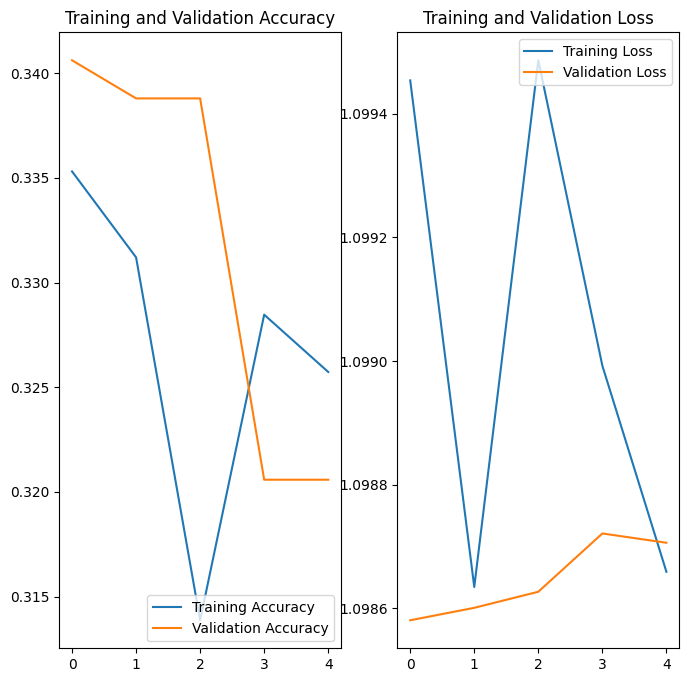

In [ ]:
train_acc_cnn_a = hist_cnn_a.history['accuracy']
valid_acc_cnn_a = hist_cnn_a.history['val_accuracy']

train_loss_cnn_a = hist_cnn_a.history['loss']
valid_loss_cnn_a = hist_cnn_a.history['val_loss']

epochs_range = range(5)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_cnn_a, label = 'Training Accuracy')
plt.plot(epochs_range, valid_acc_cnn_a, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_cnn_a, label = 'Training Loss')
plt.plot(epochs_range, valid_loss_cnn_a, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# export accuracy and loss figure
plt.savefig('cnn_a_acc_loss.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
# cnn_b

import tensorflow as tf
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

np.random.seed(1987)

with tf.device('/device:GPU:0'):

  cnn_b = tf.keras.Sequential([ # rename model

    # data augmentation steps to reduce overfitting
    tf.keras.layers.RandomFlip("horizontal"), # random horizontal flips
    tf.keras.layers.RandomRotation(45), # random rotations

    # specify convolution, activation, max pooling layers; add Dropout
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 32, padding = 'same', activation = 'relu', input_shape = (192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 32, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Dropout(0.1), # add dropout to further minimize overfitting
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 64, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 64, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 128, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 128, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 1028, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 1028, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 1028, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(kernel_size = 2, filters = 1028, padding = 'same', activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation = 'softmax')
  ])

  sgd = SGD(learning_rate = 0.01)

  cnn_b.compile(
    optimizer = sgd, # update: new optimizer
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

  # fit to training data
  hist_cnn_b = cnn_b.fit(X_train, y_train,
                   epochs = 5,
                   verbose = 1,
                   batch_size = 128, # update: increase batch size
                   validation_split = .2)
  hist_cnn_b # add model history

In [ ]:
import pprint
pprint.pprint(hist_cnn_b.history)

{'accuracy': [0.3197992742061615,
              0.3385036587715149,
              0.3362226188182831,
              0.3375912308692932,
              0.3471715450286865],
 'loss': [1.098623514175415,
          1.0983848571777344,
          1.0982162952423096,
          1.0980843305587769,
          1.0978517532348633],
 'val_accuracy': [0.32058286666870117,
                  0.32058286666870117,
                  0.3187613785266876,
                  0.3442623019218445,
                  0.4134790599346161],
 'val_loss': [1.0985640287399292,
              1.0984466075897217,
              1.0982561111450195,
              1.0981101989746094,
              1.098016619682312]}


In [ ]:
# save model
cnn_b.save('cnn_b.keras')
# tf.keras.models.load_model('cnn_b.keras')

In [ ]:
# save model history
np.save('cnn_b_history.npy',
        cnn_b.history)

# np.load('cnn_b_model_history.npy', allow_pickle = 'TRUE')

In [ ]:
cnn_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 192, 192, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 192, 192, 3)       0         
 otation)                                                        
                                                                 
 conv2d_12 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 192, 192, 32)      4128      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 96, 96, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 96, 96, 32)       

In [ ]:
# evaluate cnn_b model on test data
cnn_b_score, cnn_b_accuracy = cnn_b.evaluate(X_test, y_test)
print('Test score: ', cnn_b_score)
print('Test accuracy: ', cnn_b_accuracy)

41/41 [==============================] - 174s 4s/step - loss: 1.0986 - accuracy: 0.3338
Test score:  1.0986206531524658
Test accuracy:  0.3338497281074524


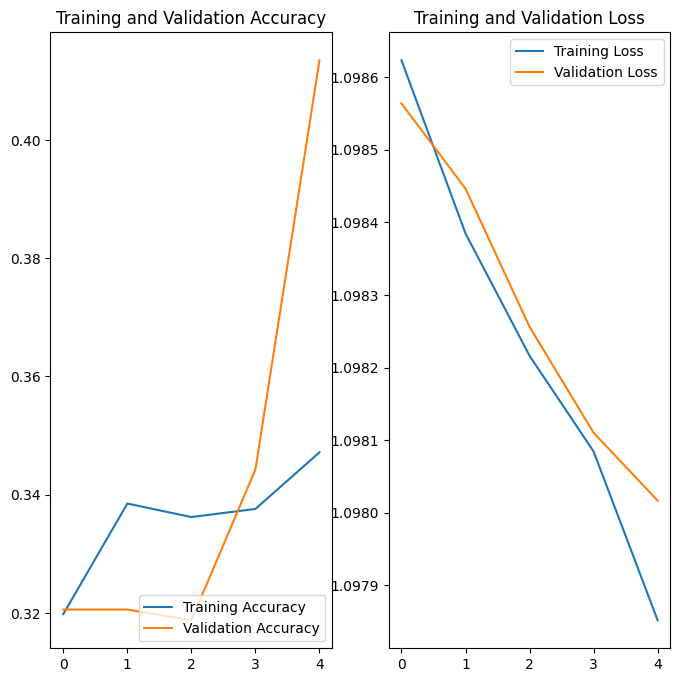

In [ ]:
# plot training and validation accuracy
# plot training and vallidation loss

train_acc_cnn_b = hist_cnn_b.history['accuracy']
valid_acc_cnn_b = hist_cnn_b.history['val_accuracy']

train_loss_cnn_b = hist_cnn_b.history['loss']
valid_loss_cnn_b = hist_cnn_b.history['val_loss']

epochs_range = range(5)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_cnn_b, label = 'Training Accuracy')
plt.plot(epochs_range, valid_acc_cnn_b, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_cnn_b, label = 'Training Loss')
plt.plot(epochs_range, valid_loss_cnn_b, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# export accuracy and loss figure
plt.savefig('cnn_b_acc_loss.png')

<Figure size 640x480 with 0 Axes>

# **STEP 6(b): Transfer Learning Models**

We proceed to train two transfer learning models on the X-ray image data, VGG19 and ResNet50 -- both of which have been pre-fitted to ImageNet data. Our transfer learning models similarly utilize categorical cross-entropy loss for comparability with the previous CNN models, and require X-ray images to first be reshaped to 224 by 224 pixels.

The pre-fine-tuned VGG19 model exhibits a marked decline in performance relative to our CNN models, with training and validation accuracies reaching only 0.253 and 0.182, respectively. The pre-fine-tuned ResNet50 model performs somewhat better versus the pre-fine-tuned VGG19 model and our CNN models, with 0.361 and 0.437 for training and validation accuracies, respectively.

The performance of the fine-tuned VGG19 and fine-tuned ResNet50 models (i.e. with base layers set as trainable) more or less plateau across epochs; the training and validation accuracies are 0.337 and 0.321 for the fine-tuned VGG19 model, and 0.3522 and 0.339 for the fine-tuned ResNet50 model, respectively. Total, trainable, and non-trainable parameter counts by model are reported in the output below.

The absence of meaningful improvement in accuracy on the part of our transfer learning models, relative to the CNN models trained earlier, may be attributable to the possibility that the original data on which these transfer learning models were trained might not correspond well to the X-ray image data of interest. Our transfer learning models also consume a particularly ample amount of processing time during their fitting to the training data; to mitigate this, we keep the epoch count to five for the initial and fine-tuned VGG19 and ResNet50 models -- a potential disadvantage in that our ability to observe potential improvements in prediction accuracy over more epochs is constrained.

In [ ]:
# reshape data to match required input shape for VGG19 and ResNet50
from keras.preprocessing import image
import numpy as np
from PIL import Image, ImageDraw

def tl_preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img = (np.float32(img) - 1.)/(255 - 1.)
        img=img.reshape((224, 224, 3))
        return img

In [ ]:
# test tl_preprocessor on an x-ray file
tl_preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(224, 224, 3)

In [ ]:
# preprocess image data for vgg19
tl_image_filepaths = fnames[0] + fnames[1] + fnames[2]
tl_preprocessed_image_data = list(map(tl_preprocessor, tl_image_filepaths))

tl_X = np.array(tl_preprocessed_image_data)

In [ ]:
# split preprocessed data for vgg19 into training and test sets
from sklearn.model_selection import train_test_split

np.random.seed(1987)

tl_X_train, tl_X_test, tl_y_train, tl_y_test = train_test_split(tl_X, y, stratify = y, test_size = 0.32, random_state = 1987)

tl_X_test.shape, tl_y_test.shape

((1291, 224, 224, 3), (1291, 3))

In [ ]:
# clear items from memory
del(tl_X)
del(y)
del(tl_preprocessed_image_data)

In [ ]:
# set up initial vgg19 model
init_vgg19 = tf.keras.applications.VGG19(
    include_top = True,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = None,
    pooling = None,
    classes = 1000,
    classifier_activation = 'softmax'
)

init_vgg19.trainable = False

# from keras docs: https://keras.io/api/applications/vgg/

574710816/574710816 [==============================] - 8s 0us/step


In [ ]:
# define additional vgg19 model layers
vgg19_inputs = tf.keras.Input(shape = (224, 224, 3))
init_vgg19_inst = init_vgg19(vgg19_inputs, training = False)
vgg19_outputs = tf.keras.layers.Dense(3)(init_vgg19_inst)

vgg19_model = tf.keras.Model(vgg19_inputs, vgg19_outputs)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

In [ ]:
np.random.seed(1987)

# compile vgg19 model
vgg19_model.compile(optimizer = 'Adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

# fit vgg19 model to training data
hist_vgg19 = vgg19_model.fit(tl_X_train, tl_y_train,
                   epochs = 5,
                   verbose = 1,
                   validation_split = .2)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

Epoch 1/5
69/69 [==============================] - 2059s 30s/step - loss: 1.0687 - accuracy: 0.2532 - val_loss: 1.0010 - val_accuracy: 0.1821
Epoch 2/5
69/69 [==============================] - 2064s 30s/step - loss: 1.0158 - accuracy: 0.1729 - val_loss: 1.0175 - val_accuracy: 0.1603
Epoch 3/5
69/69 [==============================] - 2050s 30s/step - loss: 1.0105 - accuracy: 0.1706 - val_loss: 0.9777 - val_accuracy: 0.1129
Epoch 4/5
69/69 [==============================] - 2072s 30s/step - loss: 0.9668 - accuracy: 0.1337 - val_loss: 0.9110 - val_accuracy: 0.1148
Epoch 5/5
69/69 [==============================] - 2070s 30s/step - loss: 0.9945 - accuracy: 0.1478 - val_loss: 1.1040 - val_accuracy: 0.1621


In [ ]:
# save model
vgg19_model.save('vgg19_model.keras')

# tf.keras.models.load_model('vgg19_model.keras')

In [ ]:
# save model history
np.save('vgg19_model_history.npy',
        vgg19_model.history)

# np.load('vgg19_model_history.npy', allow_pickle = 'TRUE')

In [ ]:
# fine-tune vgg19 model

np.random.seed(1987)

init_vgg19.trainable = True

vgg19_inputs_new = tf.keras.Input(shape = (224, 224, 3))
init_vgg19_inst_new = init_vgg19(vgg19_inputs_new, training = False)
vgg19_outputs_new = tf.keras.layers.Dense(3)(init_vgg19_inst_new)

vgg19_model_new = tf.keras.Model(vgg19_inputs_new, vgg19_outputs_new)

# compile vgg19 model
vgg19_model_new.compile(optimizer = 'Adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

# fit vgg19 model to training data
hist_vgg19_new = vgg19_model_new.fit(tl_X_train, tl_y_train,
                   epochs = 5,
                   verbose = 1,
                   validation_split = .2)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

In [ ]:
# fine-tune vgg19 model

np.random.seed(1987)

init_vgg19.trainable = True

vgg19_inputs_new = tf.keras.Input(shape = (224, 224, 3))
init_vgg19_inst_new = init_vgg19(vgg19_inputs_new, training = False)
vgg19_outputs_new = tf.keras.layers.Dense(3)(init_vgg19_inst_new)

vgg19_model_new = tf.keras.Model(vgg19_inputs_new, vgg19_outputs_new)

# compile vgg19 model
vgg19_model_new.compile(optimizer = 'Adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

# fit vgg19 model to training data
hist_vgg19_new = vgg19_model_new.fit(tl_X_train, tl_y_train,
                   epochs = 5,
                   verbose = 1,
                   validation_split = .2)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

Epoch 1/5
69/69 [==============================] - 82s 740ms/step - loss: 5.2932 - accuracy: 0.3330 - val_loss: 5.4901 - val_accuracy: 0.3206
Epoch 2/5
69/69 [==============================] - 35s 514ms/step - loss: 5.3384 - accuracy: 0.3367 - val_loss: 5.4901 - val_accuracy: 0.3206
Epoch 3/5
69/69 [==============================] - 36s 517ms/step - loss: 5.3384 - accuracy: 0.3367 - val_loss: 5.4901 - val_accuracy: 0.3206
Epoch 4/5
69/69 [==============================] - 36s 517ms/step - loss: 5.3384 - accuracy: 0.3367 - val_loss: 5.4901 - val_accuracy: 0.3206
Epoch 5/5
69/69 [==============================] - 38s 553ms/step - loss: 5.3384 - accuracy: 0.3367 - val_loss: 5.4901 - val_accuracy: 0.3206


In [ ]:
# return vgg19 model summary
vgg19_model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
 dense (Dense)               (None, 3)                 3003      
                                                                 
Total params: 143670243 (548.06 MB)
Trainable params: 143670243 (548.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# save model
vgg19_model_new.save('vgg19_model_new.keras')
# vgg19_model_new = tf.keras.models.load_model('/content/drive/MyDrive/vgg19_model_new.keras')

In [ ]:
# save model history
np.save('vgg19_model_new_history.npy', vgg19_model_new.history)

In [ ]:
# evaluate vgg19 model on test data
vgg19_score, vgg19_accuracy = vgg19_model_new.evaluate(tl_X_test, tl_y_test)
print('Test score: ', vgg19_score)
print('Test accuracy: ', vgg19_accuracy)

41/41 [==============================] - 887s 21s/step - loss: 5.3810 - accuracy: 0.3331
Test score:  5.381021499633789
Test accuracy:  0.3330751359462738


In [ ]:
# plot training and validation accuracy
# plot training and vallidation loss

train_acc_vgg19_new = hist_vgg19_new.history['accuracy']
valid_acc_vgg19_new = hist_vgg19_new.history['val_accuracy']

train_loss_vgg19_new = hist_vgg19_new.history['loss']
valid_loss_vgg19_new = hist_vgg19_new.history['val_loss']

epochs_range = range(5)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_vgg19_new, label = 'Training Accuracy')
plt.plot(epochs_range, valid_acc_vgg19_new, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_vgg19_new, label = 'Training Loss')
plt.plot(epochs_range, valid_loss_vgg19_new, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# export accuracy and loss figure
plt.savefig('vgg19_new_acc_loss.png')

In [ ]:
# define initial resnet50
init_resnet50 = tf.keras.applications.ResNet50(
    include_top = True,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = None,
    pooling = None,
    classes = 1000,
    classifier_activation = 'softmax'
)

init_resnet50.trainable = False

# from keras docs: https://keras.io/api/applications/resnet/

In [ ]:
# define new ResNet50 model
resnet50_inputs = tf.keras.Input(shape = (224, 224, 3))
init_resnet50_inst = init_resnet50(resnet50_inputs, training = False)
resnet50_outputs = tf.keras.layers.Dense(3)(init_resnet50_inst)

resnet50_model = tf.keras.Model(resnet50_inputs, resnet50_outputs)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

In [ ]:
# compile resnet50 model
resnet50_model.compile(optimizer = 'Adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

# fit resnet50 model to training data
hist_resnet50 = resnet50_model.fit(tl_X_train, tl_y_train,
                   epochs = 5,
                   verbose = 1,
                   validation_split = .2)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

Epoch 1/5
69/69 [==============================] - 355s 5s/step - loss: 1.1127 - accuracy: 0.3339 - val_loss: 1.1039 - val_accuracy: 0.3406
Epoch 2/5
69/69 [==============================] - 346s 5s/step - loss: 1.1004 - accuracy: 0.3193 - val_loss: 1.0956 - val_accuracy: 0.4372
Epoch 3/5
69/69 [==============================] - 346s 5s/step - loss: 1.0994 - accuracy: 0.3613 - val_loss: 1.0945 - val_accuracy: 0.3424
Epoch 4/5
69/69 [==============================] - 374s 5s/step - loss: 1.0970 - accuracy: 0.3540 - val_loss: 1.0970 - val_accuracy: 0.3406
Epoch 5/5
69/69 [==============================] - 352s 5s/step - loss: 1.0971 - accuracy: 0.3513 - val_loss: 1.0916 - val_accuracy: 0.3588


In [ ]:
# return resnet50 model summary
resnet50_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 3)                 3003      
                                                                 
Total params: 25639715 (97.81 MB)
Trainable params: 3003 (11.73 KB)
Non-trainable params: 25636712 (97.80 MB)
_________________________________________________________________


In [ ]:
# evaluate resnet50 model on test data
resnet50_score, resnet50_accuracy = resnet50_model.evaluate(tl_X_test, tl_y_test)
print('Test score: ', resnet50_score)
print('Test accuracy: ', resnet50_accuracy)

41/41 [==============================] - 158s 4s/step - loss: 1.0924 - accuracy: 0.3555
Test score:  1.0923502445220947
Test accuracy:  0.35553833842277527


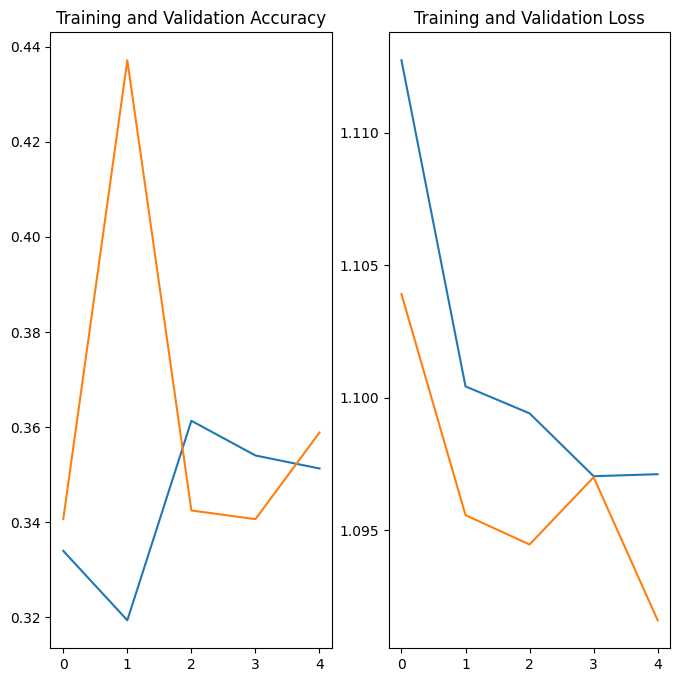

In [ ]:
# plot training and validation accuracy
# plot training and vallidation loss

train_acc_resnet50 = hist_resnet50.history['accuracy']
valid_acc_resnet50 = hist_resnet50.history['val_accuracy']

train_loss_resnet50 = hist_resnet50.history['loss']
valid_loss_resnet50 = hist_resnet50.history['val_loss']

epochs_range = range(5)

plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_resnet50, label = 'Training Accuracy')
plt.plot(epochs_range, valid_acc_resnet50, label = 'Validation Accuracy')
# plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_resnet50, label = 'Training Loss')
plt.plot(epochs_range, valid_loss_resnet50, label = 'Validation Loss')
# plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# export accuracy and loss figure
plt.savefig('resnet50_acc_loss.png')

In [ ]:
# fine-tune resnet50 model

np.random.seed(1987)

init_resnet50.trainable = True

resnet50_inputs_new = tf.keras.Input(shape = (224, 224, 3))
init_resnet50_inst_new = init_resnet50(resnet50_inputs_new, training = True)
resnet50_outputs_new = tf.keras.layers.Dense(3)(init_resnet50_inst_new)

resnet50_model_new = tf.keras.Model(resnet50_inputs_new, resnet50_outputs_new)

# re-compile resnet50 model
resnet50_model_new.compile(optimizer = 'Adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

# re-fit resnet50 model to training data
hist_resnet50_new = resnet50_model_new.fit(tl_X_train, tl_y_train,
                   epochs = 5,
                   verbose = 1,
                   validation_split = .2)

# from tensorflow docs: https://www.tensorflow.org/guide/keras/transfer_learning

Epoch 1/5
69/69 [==============================] - 1678s 24s/step - loss: 6.7354 - accuracy: 0.3522 - val_loss: 6.4224 - val_accuracy: 0.3352
Epoch 2/5
69/69 [==============================] - 1669s 24s/step - loss: 5.3468 - accuracy: 0.3399 - val_loss: 5.4901 - val_accuracy: 0.3388
Epoch 3/5
69/69 [==============================] - 1667s 24s/step - loss: 5.3751 - accuracy: 0.3321 - val_loss: 5.4901 - val_accuracy: 0.3388
Epoch 4/5
69/69 [==============================] - 1626s 24s/step - loss: 5.3604 - accuracy: 0.3321 - val_loss: 5.4901 - val_accuracy: 0.3388
Epoch 5/5
69/69 [==============================] - 1604s 23s/step - loss: 5.3751 - accuracy: 0.3321 - val_loss: 5.4901 - val_accuracy: 0.3388


In [ ]:
# save model history
np.save('resnet50_model_new_history.npy',
        hist_resnet50_new.history)

# np.load('resnet50_model_new_history.npy', allow_pickle = 'TRUE')

In [ ]:
# save model
resnet50_model_new.save('resnet50_model_new.keras')
# tf.keras.models.load_model('resnet50_model_new.keras')

In [ ]:
# return resnet50 model summary
resnet50_model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 25639715 (97.81 MB)
Trainable params: 25586595 (97.61 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# evaluate resnet50 model on test data
resnet50_score, resnet50_accuracy = resnet50_model_new.evaluate(tl_X_test, tl_y_test)
print('Test score: ', resnet50_score)
print('Test accuracy: ', resnet50_accuracy)

41/41 [==============================] - 284s 7s/step - loss: 5.4310 - accuracy: 0.3331
Test score:  5.430961608886719
Test accuracy:  0.3330751359462738


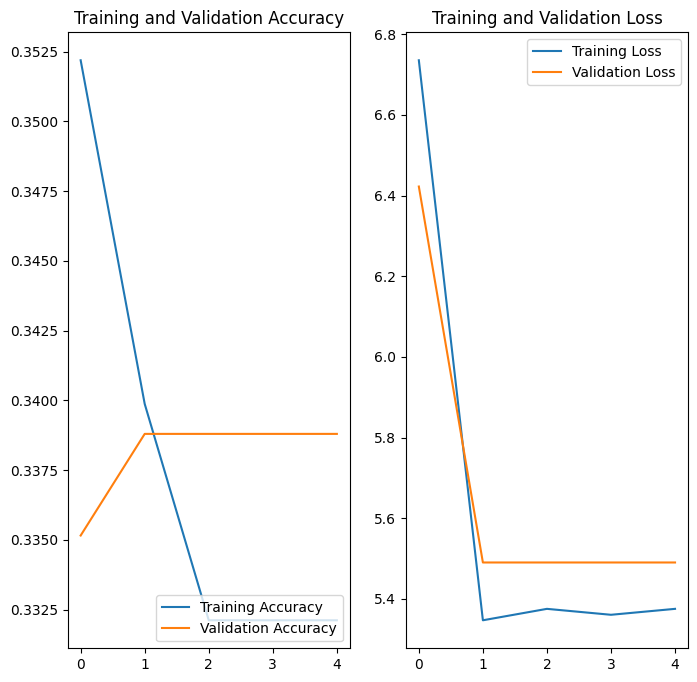

In [ ]:
# plot training and validation accuracy
# plot training and vallidation loss

train_acc_resnet50 = hist_resnet50_new.history['accuracy']
valid_acc_resnet50 = hist_resnet50_new.history['val_accuracy']

train_loss_resnet50 = hist_resnet50_new.history['loss']
valid_loss_resnet50 = hist_resnet50_new.history['val_loss']

epochs_range = range(5)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_resnet50, label = 'Training Accuracy')
plt.plot(epochs_range, valid_acc_resnet50, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_resnet50, label = 'Training Loss')
plt.plot(epochs_range, valid_loss_resnet50, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# export accuracy and loss figure
plt.savefig('resnet50_new_acc_loss.png')

<Figure size 640x480 with 0 Axes>

# **STEP 7: Sparse CNN Model <span style="color:yellow;"> (10pts)</span>**

Given the similarity in performance between the initial CNN and fine-tuned transfer learning models, we proceed to train another, more sparsely defined CNN model -- that is, with only five 2D convolution layers, four max-pooling layers, and a softmax activation layer -- to see if a reduction in model complexity yields higher prediction accuracy. We dispense with image augmentation and limit the model to one dropout layer (rate = 0.05) -- balancing the need to preserve an approach to addressing overfitting and our interest in increasing model performance. Additionally, we raise the epoch count from five to 10 in order to further allow the model to exhibit potential improvements in performance.

The result is a notable increase in the training and validation accuracies to 0.760 and 0.794, respectively. However, when we evaluate this sparse CNN model on the test data, we find that the classification accuracy reaches only 0.333 -- a sign that the model may struggle to generalize well to external data, and that retaining some level of model complexity is likely warranted.

In [ ]:
# cnn_min

import tensorflow as tf
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

np.random.seed(1987)

with tf.device('/device:GPU:0'):

  cnn_min = tf.keras.Sequential([

    # specify convolution, activation, max pooling layers; add Dropout
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 32, padding = 'same', activation = 'relu', input_shape = (192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters=64, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters=128, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(kernel_size = 3, filters = 512, padding = 'same', activation = 'relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation = 'softmax')
  ])

  cnn_min.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

  # fit CNN to training data
  hist_cnn_min = cnn_min.fit(X_train,
                             y_train,
                             epochs = 10, # update: increase number of epochs
                             verbose = 1,
                             validation_split = .2)

In [ ]:
import pprint
pprint.pprint(hist_cnn_min.history)

{'accuracy': [0.44343066215515137,
              0.6090328693389893,
              0.6920620203018188,
              0.7285584211349487,
              0.7198905348777771,
              0.727645993232727,
              0.7463503479957581,
              0.75775545835495,
              0.7600364685058594,
              0.7572992444038391],
 'loss': [29.11035919189453,
          1.2164909839630127,
          0.6849307417869568,
          0.6239978075027466,
          0.6257583498954773,
          0.6053952574729919,
          0.5670907497406006,
          0.5342736840248108,
          0.5270383358001709,
          0.5324732065200806],
 'val_accuracy': [0.630236804485321,
                  0.7049180269241333,
                  0.7340619564056396,
                  0.755919873714447,
                  0.7304189205169678,
                  0.7304189205169678,
                  0.7522768378257751,
                  0.7850637435913086,
                  0.7723132967948914,
                  0.7

In [ ]:
# save model
cnn_min.save('cnn_min.keras')
# tf.keras.models.load_model('cnn_min.keras')

In [ ]:
cnn_min = tf.keras.models.load_model('cnn_min.keras')

In [ ]:
cnn_min.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 192, 192, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 96, 96, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 128)      

In [ ]:
# save model history
np.save('cnn_min_history.npy',
        cnn_min.history)

# np.load('cnn_min_history.npy', allow_pickle = 'TRUE')

In [ ]:
cnn_min.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 192, 192, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 96, 96, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 128)      

In [ ]:
# evaluate cnn_min model on test data
cnn_min_score, cnn_min_accuracy = cnn_min.evaluate(X_test, y_test)
print('Test score: ', cnn_min_score)
print('Test accuracy: ', cnn_min_accuracy)

41/41 [==============================] - 68s 2s/step - loss: 1.0992 - accuracy: 0.3331
Test score:  1.0991685390472412
Test accuracy:  0.3330751359462738


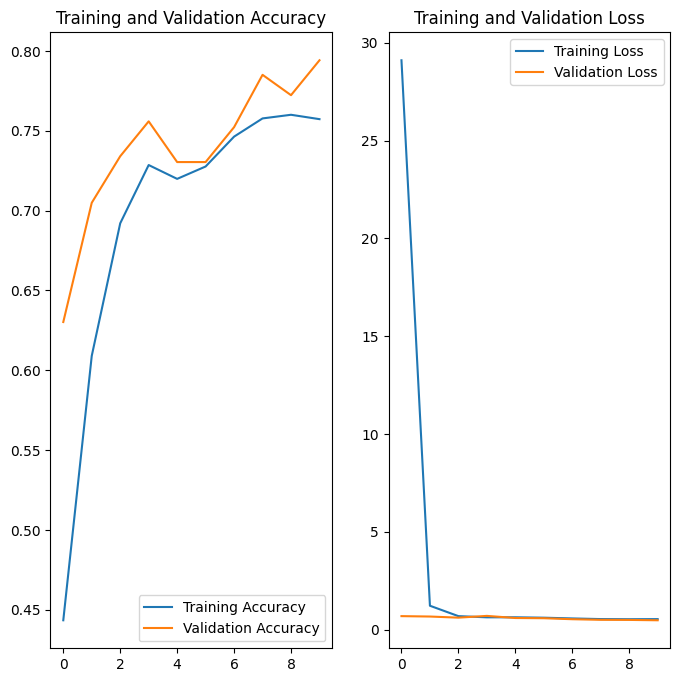

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot training and validation accuracy
# plot training and vallidation loss

train_acc_cnn_min = hist_cnn_min.history['accuracy']
valid_acc_cnn_min = hist_cnn_min.history['val_accuracy']

train_loss_cnn_min = hist_cnn_min.history['loss']
valid_loss_cnn_min = hist_cnn_min.history['val_loss']

epochs_range = range(10)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_cnn_min, label = 'Training Accuracy')
plt.plot(epochs_range, valid_acc_cnn_min, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_cnn_min, label = 'Training Loss')
plt.plot(epochs_range, valid_loss_cnn_min, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

# export accuracy and loss figure
plt.savefig('cnn_min_acc_loss.png')

In [ ]:
# export accuracy and loss figure
plt.savefig('cnn_min_acc_loss.png')

<Figure size 640x480 with 0 Axes>

**(Submission to aimodelshare is included below for reference.)**

In [ ]:
# submit cnn_min model to aimodelshare

# install aimodelshare for leaderboard submissions
! pip install aimodelshare --upgrade

In [ ]:
# save preprocessor function
import aimodelshare as ai
from aimodelshare.aws import set_credentials

ai.export_preprocessor(preprocessor, "")

apiurl = 'https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

experiment = ai.Experiment(apiurl)

set_credentials(apiurl = apiurl)

Your preprocessor is now saved to 'preprocessor.zip'
Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.


In [ ]:
# save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(cnn_min,
                            framework = 'keras',
                            transfer_learning = False,
                            deep_learning = True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# generate and save predictions for aimodelshare
import pickle

with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

prediction_column_index = cnn_min.predict(X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 66s 2s/step


In [ ]:
# submit model to competition leaderboard
experiment.submit_model(model = "model.onnx",
                        preprocessor = "preprocessor.zip",
                        prediction_submission = prediction_labels)

Insert search tags to help users find your model (optional): CNN
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 455

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

# **STEPS 8 and 9: Analysis and Conclusions (15 pts)**

Of the five image classification models fitted to the training data -- two initial CNN models with 12 2D convolution layers each, two transfer learning models (VGG19 and ResNet50), and a sparse CNN model -- we find that the sparse CNN model exhibits the best training and validation accuracy, as well as the lowest training and validation loss upon the completion of the last epoch. The modest performance of the sparse CNN model on the test data -- as well as constraints on model tuning imposed by memory limitations more generally -- speak to the need for continued experimentation with image classification models, including CNNs, other transfer learning models, and/or novel architectures.

# **STEP 10: Github Repo <span style="color:yellow;"> (15pts)</span>**

Please see repo [link](https://github.com/johnc2024/HW_2).

# **Sources<span style="color:yellow;"></span>**

Géron, A. (2019), Hands-on machine learning with SCIKIT-learn, Keras, and tensorflow: Concepts, tools, and Techniques, O’Reilly Media

J. Deng, W. Dong, R. Socher, L. -J. Li, Kai Li and Li Fei-Fei, "ImageNet: A large-scale hierarchical image database," 2009 IEEE Conference on Computer Vision and Pattern Recognition, Miami, FL, USA, 2009, pp. 248-255, https://ieeexplore.ieee.org/document/5206848

Keras Documentation: Resnet and RESNETV2, accessed April 2, 2024, https://keras.io/api/applications/resnet/

Keras Documentation: Transfer Learning & Fine-tuning, accessed April 2, 2024, https://keras.io/guides/transfer_learning/

Keras Documentation: VGG16 and VGG19, accessed April 2, 2024, https://keras.io/api/applications/vgg/

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

Transfer learning & fine-tuning: Tensorflow Core, TensorFlow, accessed April 2, 2024, https://www.tensorflow.org/guide/keras/transfer_learning